In [2]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 mlflow 2>/dev/null 

In [3]:
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution 

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score,  # For F1 score
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    # root_mean_squared_error,
)
# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [4]:
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile
import matplotlib.pyplot as plt
import seaborn as sns
# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
# use https://huggingface.co/docs/datasets/image_load for reference

# Import necessary libraries
image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm
import os
# Initialize empty lists to store file names and labels
file_names = []
labels = []

label_dict = {
    '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, 
    '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, 
    '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, 
    '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, 
    '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, 
    '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42, '43': 43, 
    '44': 44, '45': 45, '46': 46, '47': 47, '48': 48, '49': 49, '50': 50, 
    '51': 51, '52': 52, '53': 53, '54': 54, '55': 55, '56': 56, '57': 57, 
    '58': 58, '59': 59, '60': 60, '61': 61, '62': 62, '63': 63, '64': 64, 
    '65': 65, '66': 66, '67': 67, '68': 68, '69': 69, '70': 70, '71': 70, 
    '72': 70, '73': 70, '74': 70, '75': 75, '76': 75, '77': 75, '78': 75, 
    '79': 75, '80': 80, '81': 80, '82': 80, '83': 80, '84': 80, '85': 80, 
    '86': 80, '87': 80, '88': 80, '89': 80, '90': 90, '91': 90, '92': 90, 
    '93': 90, '94': 90, '95': 90, '96': 90, '97': 90, '98': 90 ,'99': 90, '100': 90
}

# Iterate through all image files in the specified directory
# for file in tqdm(sorted(Path('/kaggle/input/b3fd-simplified-structure/data/B3FD_modified/'))):
#     label = str(file).split('_')[0]  # Extract the label from the file path
#     labels.append(label_dict[label])  # Add the label to the list
#     file_names.append(str(file))  # Add the file path to the list

directory = Path('/kaggle/input/utkface-new/UTKFace/')
for file in tqdm(sorted(directory.iterdir())):  # Use .iterdir() to get the files
    if file.is_file():  # Check if the path is a file (not a directory)
        label = str(file.name).split('_')[0]  # Extract the label from the file name
        labels.append(label_dict.get(label, -1))  # Use .get() to handle missing labels
        file_names.append(str(file))

# Print the total number of file names and labels
print(len(file_names), len(labels)) 

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape) 

100%|██████████| 23708/23708 [01:44<00:00, 227.10it/s]

23708 23708
(23708, 2)


In [6]:
df.head() 

,image,label
0,/kaggle/input/utkface-new/UTKFace/100_0_0_2017...,90
1,/kaggle/input/utkface-new/UTKFace/100_0_0_2017...,90
2,/kaggle/input/utkface-new/UTKFace/100_1_0_2017...,90
3,/kaggle/input/utkface-new/UTKFace/100_1_0_2017...,90
4,/kaggle/input/utkface-new/UTKFace/100_1_0_2017...,90


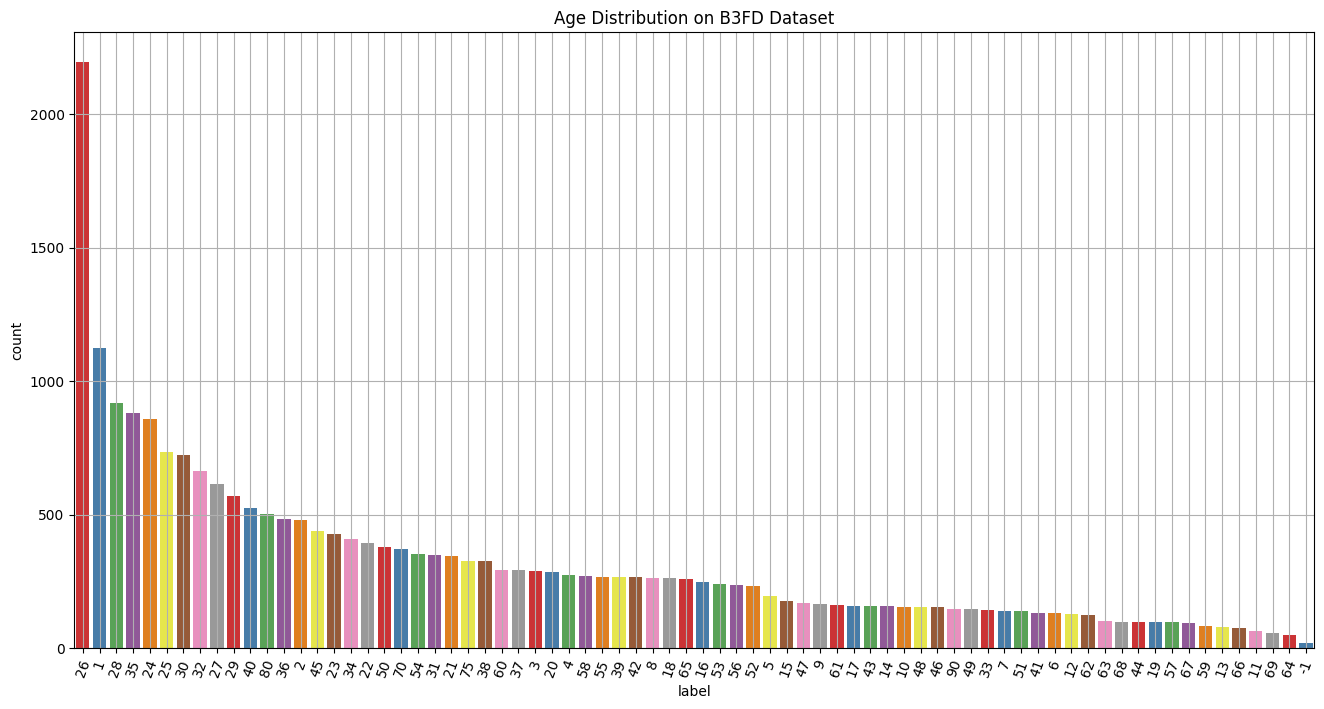

In [7]:
plt.figure(figsize=(16, 8))
plt.title('Age Distribution on B3FD Dataset') 
sns.countplot(x='label', data=df, palette='Set1', order=df['label'].value_counts().index)
plt.grid('major')
plt.xticks(rotation=70)
plt.show()

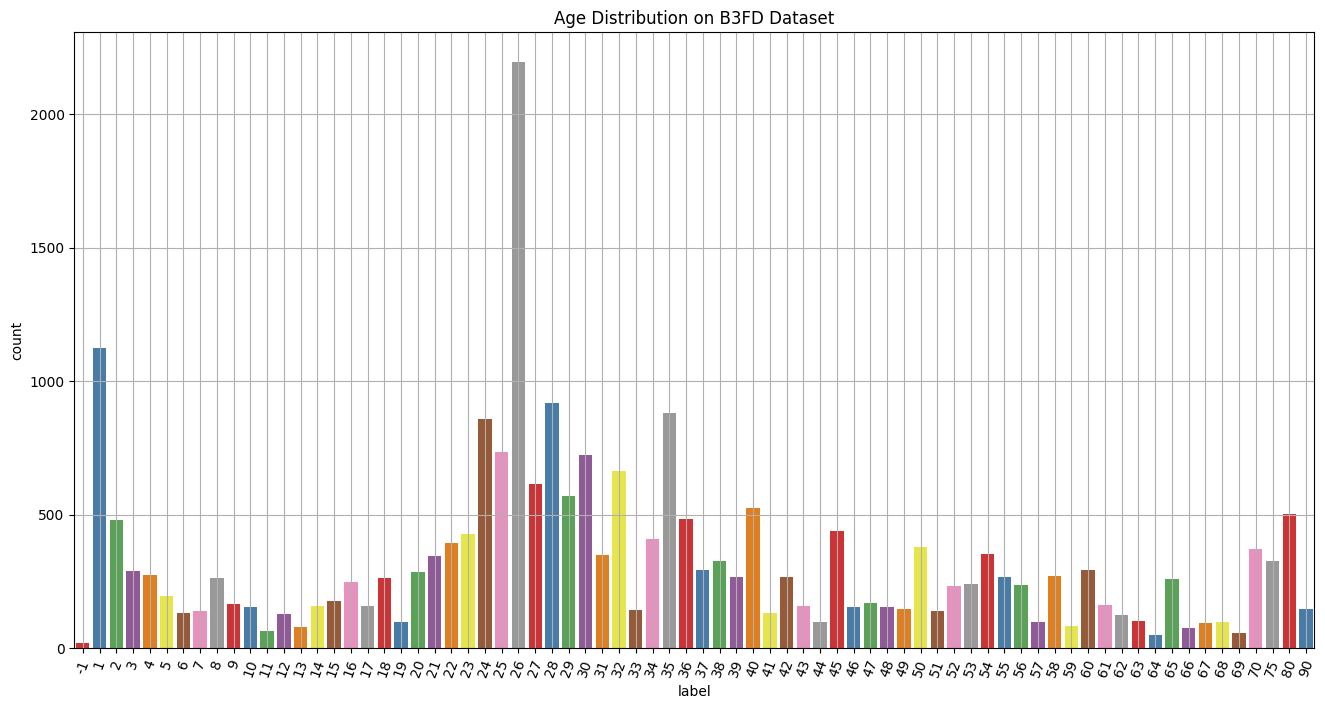

In [8]:
plt.figure(figsize=(16, 8))
plt.title('Age Distribution on B3FD Dataset') 
sns.countplot(x=df['label'], data=df, palette='Set1', order=df['label'].value_counts().sort_index().index)
plt.grid('major')
plt.xticks(rotation=70)
plt.show()

In [9]:
dataset = Dataset.from_pandas(df).cast_column("image", Image()) 

In [10]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = sorted(list(set(labels)))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: -1, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 75, 72: 80, 73: 90} 

Mapping of Labels to IDs: {-1: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48

In [11]:

# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)
print(dataset)
# Splitting the dataset into training and testing sets using an 60-40 split ratio.
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = dataset['train']
print(train_data)

# Extracting the testing data from the split dataset.
test_data = dataset['test'] 
print(test_data) 

Map:   0%|          | 0/23708 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/23708 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 23708
})
Dataset({
    features: ['image', 'label'],
    num_rows: 18966
})
Dataset({
    features: ['image', 'label'],
    num_rows: 4742
})


In [12]:
# Define the pre-trained ViT model string
model_str = "google/vit-base-patch16-224-in21k" # 'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std) 

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        RandomHorizontalFlip(0.5),        # Random horizontal flip
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples 

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Size:  224


In [13]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)

In [14]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    
    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])
    
    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

In [15]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list), ignore_mismatched_sizes=True)

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6) 

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.855562


In [16]:

accuracy = evaluate.load("accuracy")
from sklearn.metrics import r2_score

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids

    # Ensure predictions are class labels (in case they are logits/probabilities)
    predicted_labels = predictions.argmax(axis=-1)  # Adjust axis if necessary

    # Check if the shapes match
    if predicted_labels.shape != label_ids.shape:
        raise ValueError(f"Shape mismatch: predictions shape {predicted_labels.shape} vs. labels shape {label_ids.shape}")

    # Calculate Accuracy
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)["accuracy"]

    # Calculate MAE, MSE, RMSE
    mae = mean_absolute_error(label_ids, predicted_labels)
    mse = mean_squared_error(label_ids, predicted_labels)
    rmse = np.sqrt(mse)
    r2 = r2_score(label_ids, predicted_labels)


    return {
        "accuracy": acc_score,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
    }


In [17]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "MAE"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "age_recognition"

# Define the number of training epochs for the model.
num_train_epochs = 50

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,
    
    # Specify the directory where training logs will be stored.
    logging_dir='./logs',
    
    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",
    
    # Set the learning rate for the optimizer.
    learning_rate=1e-7,
    do_train = True,
    # Define the batch size for training on each device.
    per_device_train_batch_size=32,
    
    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=32,
    
    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,
    
    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,
    
    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,
    
    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,
    
    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',
    
    # Load the best model at the end of training.
    load_best_model_at_end=True,
    
    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,
    
    # Specify that training progress should not be reported
    report_to="none"  # log to none
)

In [18]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    # compute_loss_func=MSELoss(),
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [19]:
trainer.evaluate() 

{'eval_loss': 4.309401035308838,
 'eval_accuracy': 0.010965837199493884,
 'eval_MAE': 26.628637705609446,
 'eval_MSE': 1059.3220160269927,
 'eval_RMSE': 32.54722747066165,
 'eval_R2': -2.0362902612446208,
 'eval_runtime': 94.9391,
 'eval_samples_per_second': 49.948,
 'eval_steps_per_second': 0.79}

In [20]:
# Start training the model using the trainer object. 
trainer.train() 

Epoch,Training Loss,Validation Loss,Accuracy,Mae,Mse,Rmse,R2
1,No log,4.306015,0.013286,26.549135,1054.368621,32.471043,-2.022093
2,4.305300,4.302349,0.015394,26.465415,1046.501265,32.349672,-1.999543
3,4.305300,4.298715,0.019190,26.142767,1026.213201,32.034563,-1.941392
4,4.291800,4.295110,0.020666,26.009911,1017.081611,31.891717,-1.915218
5,4.291800,4.291501,0.023197,25.716575,999.424715,31.613679,-1.864609
6,4.279500,4.287942,0.028047,25.385280,975.807465,31.237917,-1.796916
7,4.265300,4.284318,0.032265,25.042176,955.288486,30.907742,-1.738103
8,4.265300,4.280735,0.037959,24.597638,934.296078,30.566257,-1.677934
9,4.251200,4.277152,0.044496,23.849642,895.639182,29.927231,-1.567133
10,4.251200,4.273633,0.050190,23.322649,868.419654,29.468961,-1.489115


TrainOutput(global_step=14850, training_loss=4.150571075336701, metrics={'train_runtime': 26302.8126, 'train_samples_per_second': 36.053, 'train_steps_per_second': 0.565, 'total_flos': 7.353307501582049e+19, 'train_loss': 4.150571075336701, 'epoch': 50.0})

In [21]:
trainer.evaluate() 

{'eval_loss': 4.203061103820801,
 'eval_accuracy': 0.14107971320118093,
 'eval_MAE': 13.166596372838464,
 'eval_MSE': 408.8055672711936,
 'eval_RMSE': 20.218940804878816,
 'eval_R2': -0.17174225010771327,
 'eval_runtime': 47.6763,
 'eval_samples_per_second': 99.462,
 'eval_steps_per_second': 1.573,
 'epoch': 50.0}

In [ ]:
# Use the trained 'trainer' to make predictions on the 'test_data'. 
outputs = trainer.predict(test_data) 

# Print the metrics obtained from the prediction outputs. 
print(outputs.metrics) 
for i in outputs.metrics:
    print(i, outputs.metrics[i]) 

In [ ]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(8, 6)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 250:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(12, 10))
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4)) 

In [ ]:
# Save the trained model: This line of code is responsible for saving the model
# that has been trained using the trainer object. It will serialize the model
# and its associated weights, making it possible to reload and use the model
# in the future without the need to retrain it.
trainer.save_model()

In [ ]:
# Import the 'pipeline' function from the 'transformers' library.
from transformers import pipeline

# Create a pipeline for image classification tasks. 
# You need to specify the 'model_name' and the 'device' to use for inference.
# - 'model_name': The name of the pre-trained model to be used for image classification.
# - 'device': Specifies the device to use for running the model (0 for GPU, -1 for CPU).
pipe = pipeline('age-recognition', model=model_name, device=0)

In [ ]:
!zip /kaggle/working/age_recognition.zip -r /kaggle/working/age_recognition 